## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unzip Data


In [2]:
# Unzip the speech audio files from Drive, overwriting if they exist
!unzip -o /content/drive/MyDrive/Mars25/Audio_Speech_Actors_01-24.zip -d ./Audio

# Unzip the song audio files from Drive, overwriting if they exist
!unzip -o /content/drive/MyDrive/Mars25/Audio_Song_Actors_01-24.zip -d ./Audio

Archive:  /content/drive/MyDrive/Mars25/Audio_Speech_Actors_01-24.zip
   creating: ./Audio/Actor_01/
  inflating: ./Audio/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ./Audio/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: ./Audio/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: ./Audio/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: ./Audio/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: ./Audio/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: ./Audio/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: ./Audio/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: ./Audio/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: ./Audio/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: ./Audio/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: ./Audio/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: ./Audio/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: ./Audio/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: ./Audio/Actor_01/03-01-03-01-02-01-01.wav  
  inflating: ./Audio/Actor_01/03-01-03-01-02

## Import Necessary Libraries

In [3]:
import os
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import random

## Set Random Seed

In [4]:
SEED = 42
tf.keras.utils.set_random_seed(SEED) # Sets seeds for TensorFlow, NumPy, and Python random
np.random.seed(SEED) # Explicitly set NumPy seed (redundant with tf.keras.utils.set_random_seed, but harmless)
random.seed(SEED)

## Parse Audio Files and Create DataFrame

In [ ]:
audio_directory = './Audio'

# List to store data
file_data = []

# Map emotion codes to actual emotions
emotion_mapping = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Iterate through all files in the directory
for dirname, _, filenames in os.walk(audio_directory):
    for filename in filenames:
        if filename.endswith('.wav'):
            file_path = os.path.join(dirname, filename)
            # Extract features from filename (e.g., 03-01-06-01-02-01-12.wav)
            parts = filename.split('-')

            modality = parts[0] # 03 = audio-only
            vocal_channel = parts[1] # 01 = speech, 02 = song
            emotion_code = parts[2] # e.g., 06 = fearful
            emotional_intensity = parts[3] # 01 = normal, 02 = strong
            statement = parts[4] # 01 = "Kids", 02 = "Dogs"
            repetition = parts[5] # 01 = 1st, 02 = 2nd
            actor = int(parts[6].split('.')[0]) # e.g., 12 = actor 12

            gender = 'male' if actor % 2 != 0 else 'female'

            file_data.append({
                'filepath': file_path,
                'modality': modality,
                'vocal_channel': vocal_channel,
                'emotion_code': emotion_code,
                'emotion': emotion_mapping.get(emotion_code, 'unknown'),
                'intensity': emotional_intensity,
                'statement': statement,
                'repetition': repetition,
                'actor': actor,
                'gender': gender
            })

# Create a DataFrame
df = pd.DataFrame(file_data)
print(f"Total files loaded: {len(df)}")
print("\nDataFrame Head:")
print(df.head())
print("\nEmotion Distribution:")
print(df['emotion'].value_counts())

Total files loaded: 2452

DataFrame Head:
                                    filepath modality vocal_channel  \
0  ./Audio/Actor_16/03-01-04-01-01-01-16.wav       03            01   
1  ./Audio/Actor_16/03-01-05-01-02-02-16.wav       03            01   
2  ./Audio/Actor_16/03-02-04-02-02-01-16.wav       03            02   
3  ./Audio/Actor_16/03-02-06-01-02-02-16.wav       03            02   
4  ./Audio/Actor_16/03-01-04-02-01-02-16.wav       03            01   

  emotion_code  emotion intensity statement repetition  actor  gender  
0           04      sad        01        01         01     16  female  
1           05    angry        01        02         02     16  female  
2           04      sad        02        02         01     16  female  
3           06  fearful        01        02         02     16  female  
4           04      sad        02        01         02     16  female  

Emotion Distribution:
emotion
sad          376
angry        376
fearful      376
happy        376


## Feature Extraction

In [ ]:
def extract_comprehensive_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None) # sr=None to keep original sample rate

        features_list = []

        # 1. MFCCs (40 coefficients)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        features_list.append(np.mean(mfccs, axis=1))
        features_list.append(np.std(mfccs, axis=1))

        # 2. Delta MFCCs
        mfccs_delta = librosa.feature.delta(mfccs)
        features_list.append(np.mean(mfccs_delta, axis=1))
        features_list.append(np.std(mfccs_delta, axis=1))

        # 3. Delta-Delta MFCCs
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
        features_list.append(np.mean(mfccs_delta2, axis=1))
        features_list.append(np.std(mfccs_delta2, axis=1))

        # 4. Chroma Feature
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        features_list.append(np.mean(chroma, axis=1))
        features_list.append(np.std(chroma, axis=1))

        # 5. MEL Spectrogram Feature
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_db = librosa.power_to_db(mel, ref=np.max) # Convert to dB scale
        features_list.append(np.mean(mel_db, axis=1))
        features_list.append(np.std(mel_db, axis=1))

        # 6. Spectral Contrast Feature
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
        features_list.append(np.mean(contrast, axis=1))
        features_list.append(np.std(contrast, axis=1))

        # 7. Tonnetz Feature
        # Requires harmonic-percussive source separation for better results
        y_harmonic, y_percussive = librosa.effects.hpss(audio)
        tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sample_rate)
        features_list.append(np.mean(tonnetz, axis=1))
        features_list.append(np.std(tonnetz, axis=1))

        # 8. Zero Crossing Rate (ZCR)
        zcr = librosa.feature.zero_crossing_rate(y=audio)
        features_list.append(np.mean(zcr, axis=1))
        features_list.append(np.std(zcr, axis=1))

        # 9. Root Mean Square (RMS) Energy
        rms = librosa.feature.rms(y=audio)
        features_list.append(np.mean(rms, axis=1))
        features_list.append(np.std(rms, axis=1))

        # Concatenate all features into a single vector
        features = np.concatenate(features_list)

        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

print("\nExtracting comprehensive rich features (including Delta/Delta-Delta MFCCs, Tonnetz, ZCR, RMS) - this may take a while...")
df['features'] = df['filepath'].apply(extract_comprehensive_features)

# Remove rows where feature extraction failed (if any)
df.dropna(subset=['features'], inplace=True)
print(f"Total files after feature extraction (excluding errors): {len(df)}")
if not df.empty:
    print(f"Shape of first extracted feature vector: {df['features'].iloc[0].shape}")
else:
    print("No valid features were extracted.")


Extracting comprehensive rich features (including Delta/Delta-Delta MFCCs, Tonnetz, ZCR, RMS) - this may take a while...
Total files after feature extraction (excluding errors): 2452
Shape of first extracted feature vector: (550,)


## Save the extracted Features in a .pkl file

In [ ]:
print("\nSaving extracted features DataFrame to 'ravdess_features.pkl'...")
try:
    df.to_pickle('ravdess_features.pkl')
    print("Features DataFrame saved successfully as 'ravdess_features.pkl'!")
    print("In future sessions, you can load it using: df = pd.read_pickle('ravdess_features.pkl')")
except Exception as e:
    print(f"Error saving features: {e}")


## Load the extracted features

In [5]:
print("\nLoading pre-extracted features from 'ravdess_features.pkl'...")
try:
    df = pd.read_pickle('ravdess_features.pkl')
    print(f"Features DataFrame loaded successfully. Total files: {len(df)}")
    print("DataFrame Head (from loaded file):")
    print(df.head())
    print("\nEmotion Distribution (from loaded file):")
    print(df['emotion'].value_counts())
except FileNotFoundError:
    print("Error: 'ravdess_features.pkl' not found. Please ensure feature extraction was completed and saved.")
except Exception as e:
    print(f"Error loading features: {e}")


Loading pre-extracted features from 'ravdess_features.pkl'...
Features DataFrame loaded successfully. Total files: 2452
DataFrame Head (from loaded file):
                                    filepath modality vocal_channel  \
0  ./Audio/Actor_14/03-02-06-02-01-01-14.wav       03            02   
1  ./Audio/Actor_14/03-01-02-02-02-01-14.wav       03            01   
2  ./Audio/Actor_14/03-02-02-01-01-02-14.wav       03            02   
3  ./Audio/Actor_14/03-01-05-01-02-01-14.wav       03            01   
4  ./Audio/Actor_14/03-01-02-02-01-01-14.wav       03            01   

  emotion_code  emotion intensity statement repetition  actor  gender  \
0           06  fearful        02        01         01     14  female   
1           02     calm        02        02         01     14  female   
2           02     calm        01        01         02     14  female   
3           05    angry        01        02         01     14  female   
4           02     calm        02        01         

## Feature Selection (Random Forest Importances)

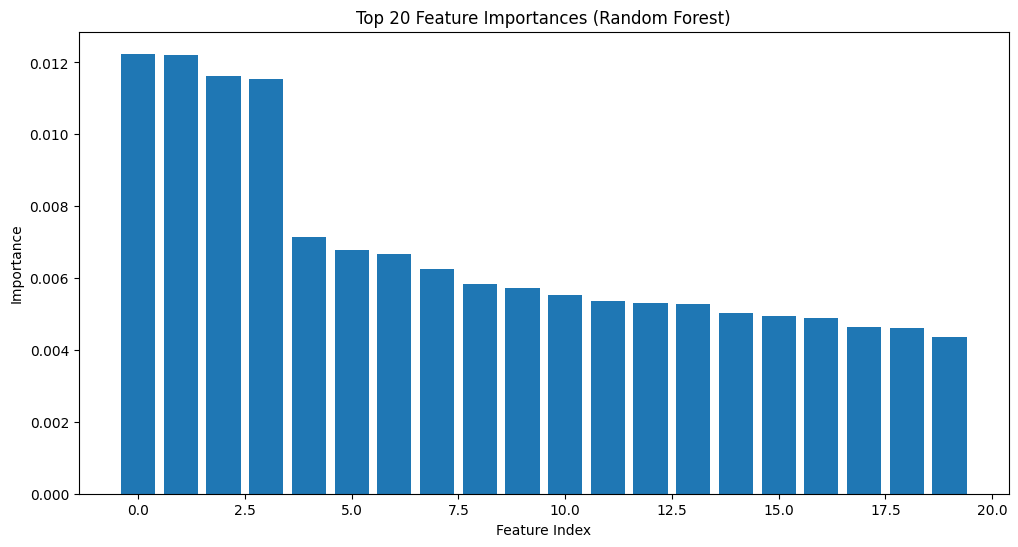

In [6]:
X = np.array(df['features'].tolist())
y = np.array(df['emotion'].tolist())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y_encoded)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.bar(range(20), importances[indices[:20]], align="center")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# Select top N features
N = 275
top_indices = indices[:N]
X_selected = X[:, top_indices]

## Train/Validation Split and Scaling

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

## Bootstrapping (Oversampling) for Balanced Training

In [8]:
from collections import Counter

print("Original training class distribution:", Counter(y_train))
np.random.seed(SEED)
random.seed(SEED)

max_class_count = max(Counter(y_train).values())
X_train_resampled = []
y_train_resampled = []

for class_label in np.unique(y_train):
    class_indices = np.where(y_train == class_label)[0]
    if len(class_indices) < max_class_count:
        resampled_indices = np.random.choice(
            class_indices,
            size=max_class_count,
            replace=True
        )
        X_train_resampled.extend(X_train_scaled[resampled_indices])
        y_train_resampled.extend(y_train[resampled_indices])
    else:
        X_train_resampled.extend(X_train_scaled[class_indices])
        y_train_resampled.extend(y_train[class_indices])

X_train_resampled = np.array(X_train_resampled)
y_train_resampled = np.array(y_train_resampled).astype(int)

shuffle_indices = np.arange(len(X_train_resampled))
np.random.shuffle(shuffle_indices)
X_train_processed = X_train_resampled[shuffle_indices]
y_train_processed = y_train_resampled[shuffle_indices]

print("Resampled training class distribution:", Counter(y_train_processed))

Original training class distribution: Counter({np.int64(3): 301, np.int64(0): 301, np.int64(1): 301, np.int64(6): 301, np.int64(4): 301, np.int64(7): 153, np.int64(2): 153, np.int64(5): 150})
Resampled training class distribution: Counter({np.int64(6): 301, np.int64(4): 301, np.int64(1): 301, np.int64(2): 301, np.int64(0): 301, np.int64(5): 301, np.int64(7): 301, np.int64(3): 301})


## Model Training (ANN)

In [9]:
SEED = 42
keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train_processed.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=20,
    min_lr=0.00001,
    verbose=1
)

history = model.fit(
    X_train_processed, y_train_processed,
    epochs=500,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3132 - loss: 2.1205 - val_accuracy: 0.5682 - val_loss: 1.2934 - learning_rate: 0.0010
Epoch 2/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5692 - loss: 1.2291 - val_accuracy: 0.6354 - val_loss: 1.0140 - learning_rate: 0.0010
Epoch 3/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6572 - loss: 0.9683 - val_accuracy: 0.7006 - val_loss: 0.8806 - learning_rate: 0.0010
Epoch 4/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7329 - loss: 0.7979 - val_accuracy: 0.7189 - val_loss: 0.7921 - learning_rate: 0.0010
Epoch 5/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7667 - loss: 0.6663 - val_accuracy: 0.7495 - val_loss: 0.7636 - learning_rate: 0.0010
Epoch 6/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7694 - loss: 0.6364 - val_accuracy: 0.7271 - val_loss: 0.7492 - learning_rate: 0.0010
Epoch 7/500
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8070 - loss: 0.5578 - val_ac

## Model Evaluation


--- Evaluation of Artificial Neural Network (ANN) Model ---
Overall Accuracy: 0.8717
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
F1 Score (Macro Average): 0.8677

Classification Report (ANN Model):
              precision    recall  f1-score   support

       angry       0.89      0.91      0.90        75
        calm       0.87      0.95      0.90        75
     disgust       0.84      0.82      0.83        39
     fearful       0.90      0.84      0.87        75
       happy       0.92      0.93      0.93        75
     neutral       0.94      0.82      0.87        38
         sad       0.78      0.80      0.79        75
   surprised       0.85      0.85      0.85        39

    accuracy                           0.87       491
   macro avg       0.87      0.86      0.87       491
weighted avg       0.87      0.87      0.87       491



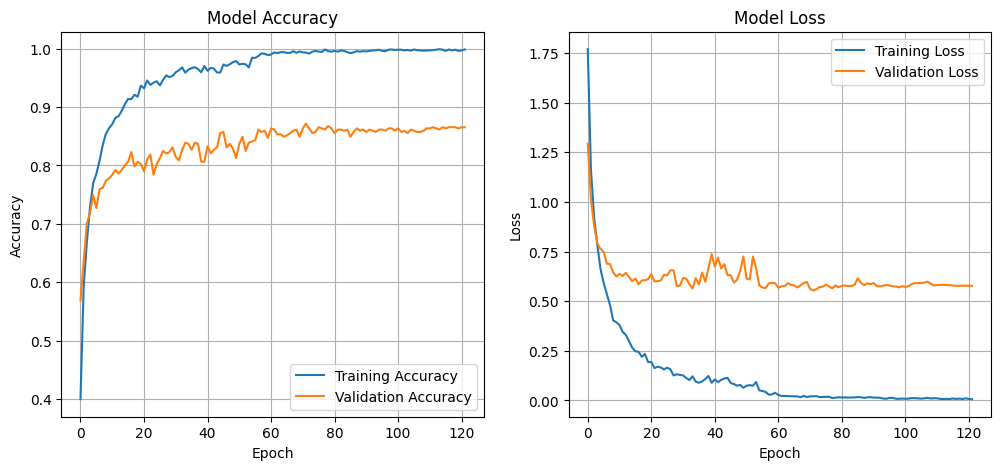

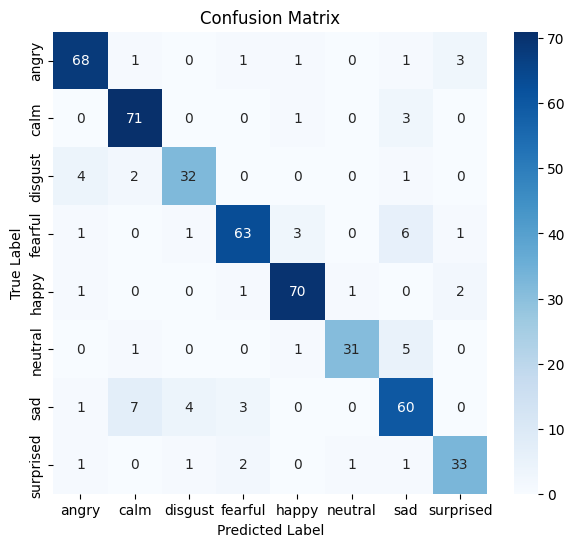

In [10]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Evaluation of Artificial Neural Network (ANN) Model ---")

loss, accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)
print(f"Overall Accuracy: {accuracy:.4f}")

y_pred_probs_ann = model.predict(X_val_scaled)
y_pred_ann = np.argmax(y_pred_probs_ann, axis=1)

f1_macro_ann = f1_score(y_val, y_pred_ann, average='macro')
print(f"F1 Score (Macro Average): {f1_macro_ann:.4f}")

print("\nClassification Report (ANN Model):")
print(classification_report(y_val, y_pred_ann, target_names=label_encoder.classes_))

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_ann)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
model.save('emotion_ann_model.h5')
print("Model saved as 'emotion_ann_model.h5'")

Model saved as 'emotion_ann_model.h5'
